## Subgroup B Question 3

How can we better allocate resources (staff, capacity) across different attractions and services to meet varying demand?
1. Develop a model to optimize resource allocation across the venue.
2. Incorporate factors such as peak hours, special events, and seasonal variations.

### Answering point 1
The resources for this question will be the total number of staff. For attractions that require a longer wait time, we allocate more resources (staff) to that attraction. More staff means they can perform shifts, work faster in processing guests, and cater to those waiting in the queue like providing snacks or drinks. This could potentially shorten wait time, but mainly increase guest satisfaction and revenue, which aligns with the business objectives.

#### Modelling
The "model" in this case is not a typical machine learning model as they are mainly used for predictions, but our problem deals with Optimization. We instead use Linear Optimization, as we want to optimise an objective given resource limitations. We will also consider a greedy approach to minimise wait time. Since there are 2 models, we will choose the model that allocates more staff to the attraction that has the highest wait time.

The good thing about greedy heuristic is that it always finds a feasible solution. It does so by iteratively reducing the wait time of the attraction with the longest wait time. However, the limitation of linear optimization is that it may fail to find feasible solutions sometimes. This doesn't mean that the linear optimization's solution is automatically better, but it allows the stakeholder to compare between the two allocations.

### Answering point 2
We will be making use of the predictions of guest flow and demand from Subgroup B Question 1 to optimize staff allocation for a certain day. The predictions incorporated factors like special events, seasonal variations and wait times from the previous day. This fits the needs of the requirements for point 2, excluding peak hours.

#### Factors
The predicted wait times is able to factor in most of the necessary factors like special events and seasonal variations, except for peak hours. Since we are utilising all staff that has been allocated to rides, like if 500 staff were allocated to handling rides, then all 500 of them will be allocated, instead of 250 or a lower number. It is therefore safe to assume that peak hours has been accounted for in our optimal allocation.

### Important note
Some numbers written in the markdown like using 280 total staff and 1 minimum staff per attraction due to the intersection may not always be true. Since our forecasted dates are constantly changing, and we always pick a random date to be used for our analysis, the numbers in the markdown may not reflect what is actually present in the graph. Refer to the code instead for more precise details when reviewing.

In [3]:
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
import pulp
import numpy as np
import time

### Collated forecasts per ride

Subgroup B Question 1 has provided us with collated_forecasts_per_ride.csv, which is a forecast of the wait times for each ride for a specific day.

In [4]:
collated_forecasts_df = pd.read_csv('../data/collated_forecasts_per_ride.csv')

### Choice of date

Since wait times vary by date, we pick a particular date to optimise staff allocation on. For now, we set it to be a random date in the data.

In [5]:
all_dates = collated_forecasts_df['date'].unique()
all_dates

array(['2024-10-22', '2024-10-23', '2024-10-24', '2024-10-25',
       '2024-10-26', '2024-10-27', '2024-10-28', '2024-10-29',
       '2024-10-30', '2024-10-31', '2024-11-01', '2024-11-02',
       '2024-11-03', '2024-11-04'], dtype=object)

Depending on the needs of the user, they can change the date to any date that has been forecasted.

In [6]:
date = all_dates[randint(0, all_dates.shape[0]-1)]
date

'2024-10-25'

### wait_times Dictionary 

This dictionary simply maps the attraction names to their forecasted wait time for the date we chose above. This allows us to handle the Linear Optimization later easier.

The dictionary also has been sorted by the forecasted wait time in ascending order as we want to compare the bar plots of attractions vs. forecasted wait time and attractions vs. staff allocated to see if they would look similar.

In [7]:
forecasts_df = collated_forecasts_df[collated_forecasts_df['date'] == date]
wait_times = dict(sorted(zip(forecasts_df['attraction_name'], forecasts_df['forecast']), key = lambda x:x[1]))
wait_times

{'[The Lost World] Hatched! Featuring Dr. Rooney': 0.0,
 '[Far Far Away] Puss In Boots Giant Journey': 0.0,
 '[The Lost World] Raptor Encounter with Blue': 3.624416988653141,
 '[Sci-Fi City] Sci-Fi Games': 4.247951364622887,
 '[Hollywood] Trolls Hug Time Jubilee': 4.97870371843059,
 '[Far Far Away] Donkey Live': 5.378414481248464,
 '[Far Far Away] Magic Potion Spin': 6.868807672470417,
 '[The Lost World] WaterWorld': 11.915623079040062,
 '[Ancient Egypt] Treasure Hunters': 12.636547392466712,
 '[Far Far Away] Happily Ever After': 13.162829887422602,
 '[The Lost World] Dino-Soarin': 14.332005483428992,
 '[Sci-Fi City] TRANSFORMERS: Voices of Cybertron': 14.97502078002447,
 '[New York] Lights, Camera, Action!': 15.920180482419395,
 '[Sci-Fi City] Accelerator': 16.095520784515124,
 '[Far Far Away] Shrek 4-D Adventure': 20.23618348090842,
 '[New York] Sesame Street Spaghetti Chase': 24.1332976425557,
 '[The Lost World] Canopy Flyer': 26.37428431514921,
 '[Far Far Away] Enchanted Airways': 

In [8]:
attractions = list(wait_times.keys())
num_of_attractions = len(attractions)

forecasts = list(wait_times.values())

### Bar plot of Attractions vs. Forecasts

This allows us to see which rides require a higher wait time. It also allows us to verify later if the optimised answer would make sense.

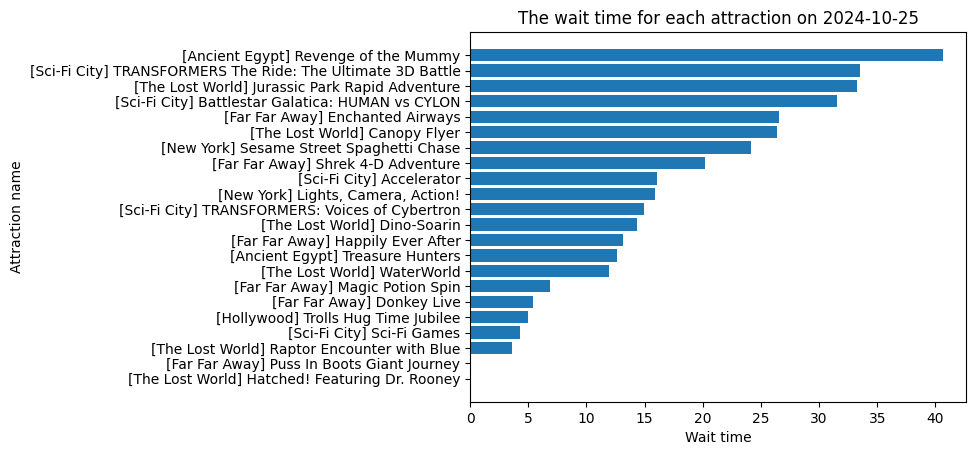

In [9]:
fig_forecast, ax_forecast = plt.subplots()
attractions_list = list(attractions)
forecasts_list = list(forecasts)
ax_forecast.barh(attractions_list, forecasts_list)
ax_forecast.set_xlabel("Wait time")
ax_forecast.set_ylabel("Attraction name")
ax_forecast.set_title(f"The wait time for each attraction on {date}")
plt.show()

### Staff numbers

total_staff refers to the total number of staff working on a particular day. It has been set to an arbitrary number. This number is subject to change depending on the actual number of staff working on a particular day.

min_staff_per_attraction refers to the minimum number of staff required at a ride. It has also been set to an arbitrary number. This number depends on the needs of USS.

In [10]:
total_staff = 500
min_staff_per_attraction = 5

### Mininum staffing checker

This part is for ensuring that the minimum staff per attraction is within bounds to ensure that the code will work.

In [11]:
def check_min_staff(total_staff, min_staff_per_attraction):
    # If user entered negative value, then set minimum to 0
    if min_staff_per_attraction < 0:
        min_staff_per_attraction = 0
        print("Minimum staff per attraction changed to 0")
    
    # Let's say there are 10 attractions, and 10 total staff. We can't have
    # 2 staff per attractions, as that would mean there are 20 total staff.
    # This statement ensures logical allocations.
    elif min_staff_per_attraction >= total_staff//num_of_attractions+1:
        min_staff_per_attraction = total_staff//num_of_attractions
        print(f"Minimum staff per attraction changed to {min_staff_per_attraction}")

    # Let's say there are 10 attractions, and 9 total staff. We can't even
    # have 1 staff per attraction, so we automatically make minimum to be 0.
    if total_staff < num_of_attractions:
        min_staff_per_attraction = 0
        print("Minimum staff per attraction changed to 0")
    
    return min_staff_per_attraction

min_staff_per_attraction = check_min_staff(total_staff, min_staff_per_attraction)

## Linear Optimization

### Objective function
Our objective is to minimise the total deviation from the target or optimal allocation for each attraction. This can be represented as:
$$\text{Minimize } \sum_{i=1}^{n} d_i$$
where: 
- $d_i$: the deviation of the staff allocated from the target staff allocated for attraction $i$

### Constraints
Constraint 1: the sum of staff allocations across all attractions should not exceed the total number of staff available. This can be represented as:
$$\sum_{i=1}^{n} x_i \leqslant T$$
where:
- $x_i$: the number of staff allocated to attraction $i$
- $T$: the total number of staff available on the chosen date

Constraint 2: each ride must have at least the minimum number of required staff, as assigned by USS. This can be represented as:
$$x_i \geqslant m \quad \forall i \in {1,2,...,n}$$
where:
- $x_i$: the number of staff allocated to attraction $i$
- $m$: the minimum number of staff to be allocated per ride

Constraint 3: each ride's staff allocation needs to be close to its target proportional allocation, with some minor deviations. This can be represented as:
$$x_i = target_i + d_i$$
where:
- $x_i$: the number of staff allocated to attraction $i$
- $d_i$: the devation of the staff allocated from the target staff allocated for attraction $i$

In [12]:
def get_allocation_linear(date, total_staff, min_staff_per_attraction, show_feasibility):
    # Initialize variables
    forecasts_df = collated_forecasts_df[collated_forecasts_df['date'] == date]
    wait_times = dict(sorted(zip(forecasts_df['attraction_name'], forecasts_df['forecast']), key = lambda x:x[1]))
    attractions = list(wait_times.keys())
    forecasts = list(wait_times.values())

    # Problem setup
    problem = pulp.LpProblem("Proportional_Staff_Allocation_Optimization", pulp.LpMinimize)

    # Decision variables
    staff_allocation = pulp.LpVariable.dicts("Staff", attractions, lowBound=min_staff_per_attraction, cat="Integer")
    deviation = pulp.LpVariable.dicts("Deviation", attractions, lowBound=0, cat="Continuous")

    # Objective function
    problem += pulp.lpSum(deviation[attraction] for attraction in attractions)

    # Constraint 1
    problem += pulp.lpSum(staff_allocation[attraction] for attraction in attractions) <= total_staff, "TotalStaffConstraint"

    # Constraint 2
    for attraction in attractions:
        problem += staff_allocation[attraction] >= min_staff_per_attraction

    # Constraint 3
    for attraction in attractions:
        target_allocation = {attraction: int(total_staff * (wait / sum(forecasts))) for attraction, wait in wait_times.items()}[attraction]
        problem += staff_allocation[attraction] == target_allocation + deviation[attraction] - deviation.get(f"neg_{attraction}", 0)

    # Solving the problem
    feasible = problem.solve()

    if show_feasibility:
        if feasible == 1:
            print("Linear Optimization has found a feasible solution.")
        else:
            print("Linear Optimization has not found a feasible solution, change total staff or minimum staff per attraction.")

    # Extract staff allocation and place into dictionary
    optimal_allocation_linear = {attraction: staff_allocation[attraction].varValue for attraction in attractions}

    return optimal_allocation_linear, feasible

### Displaying the optimal staff allocation

The output comes from the linear Optimization problem as solved from above.

In [13]:
optimal_allocation_linear, feasible = get_allocation_linear(date, total_staff, min_staff_per_attraction, True)
print("Optimal Staff Allocation:")
for attraction, staff in optimal_allocation_linear.items():
    print(f"{attraction}: {staff} staff")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/a807b28807f74f439b2d48750686cdbf-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/a807b28807f74f439b2d48750686cdbf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 205 RHS
At line 251 BOUNDS
At line 274 ENDATA
Problem MODEL has 45 rows, 44 columns and 88 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 990 to -1.79769e+308
Probing was tried 0 times and creat

### Bar plot of Attractions vs. Staff allocations

This allows us to see which rides require a higher number of staff to be allocated. 

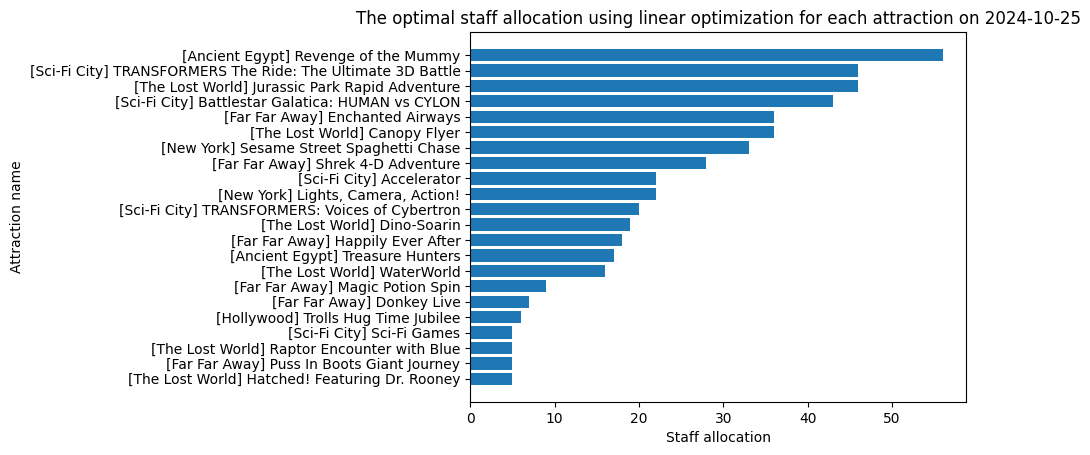

In [14]:
fig_linear, ax_linear = plt.subplots()
ax_linear.barh(list(optimal_allocation_linear.keys()), list(optimal_allocation_linear.values()))
ax_linear.set_xlabel("Staff allocation")
ax_linear.set_ylabel("Attraction name")
ax_linear.set_title(f"The optimal staff allocation using linear optimization for each attraction on {date}")
plt.show()


### Some thoughts on Linear Optimization

As can be seen from above, the two bar plots of attraction vs. wait time and attraction vs. staff allocation are very similar. 

This gives us some interpretation of the solution generated from the linear Optimization model. It would make sense that an attraction that has a higher waiting time would need more staff allocated to it. This would result in a proportionate output where the staff allocations are proportionally equal to the waiting times for all the attractions. So, the output is trivial in a sense as it can already be derived just from looking at the first bar plot without the need for the Linear Optimization model.

Linear Optimization may not always work. It sometimes fails to find a feasible solution. This gives us a need to find another approach that allows us to tackle the problem in not just a multi-faceted manner, but also more consistent in giving the user a satisfactory allocation.

## Greedy Heuristic

Rather than viewing the problem as minimising the total deviation from the target allocation, we can instead view it more simply as minimising the wait times, if we assume that allocating 1 staff to an attraction would reduce the wait time. 

We can view our new problem as a non-linear Optimization problem, but taking a greedy approach is much simpler to understand and interpret. It is greedy as we are always allocating staff to the attraction that requires the highest time.

### Wait time

The wait time for each attraction $i$ after allocating $x_i$ staff can be represented as:
$$\text{(adjusted wait time)}_i = w_i \times \text{(reduction factor)}^{x_i - m}$$
where:
- $\text{(reduction factor)}$: each additional staff reduces the wait time by a factor, if $w_i=100$ and $\text{(reduction factor)}=0.9$, then having 1 additional staff would mean $\text{(adjusted wait time)}_i=100*0.9^{6-5}=90$
- $w_i$: wait time for attraction $i$
- $m$: the minimum number of staff to be allocated per ride

### Total wait time

Using the previous adjusted wait time function, the total wait time after adjustment can be represented as:
$$\text{total wait time} = \sum_{i=1}^n \text{(adjusted wait time)}_i = \sum_{i=1}^{n} w_i \times \text{(reduction factor)}^{x_i - m}$$

### Objective function
Our objective is to minimise the total adjusted wait time. This can be represented as:
$$\text{Minimize } \sum_{i=1}^{n} w_i \times \text{(reduction factor)}^{x_i - m}$$

### Constraints
Constraint 1: the sum of staff allocations across all attractions should not exceed the total number of staff available. This can be represented as:
$$\sum_{i=1}^{n} x_i \leqslant T$$
where:
- $x_i$: the number of staff allocated to attraction $i$
- $T$: the total number of staff available on the chosen date

Constraint 2: each ride must have at least the minimum number of required staff, as assigned by USS. This can be represented as:
$$x_i \geqslant m \quad \forall i \in {1,2,...,n}$$
where:
- $x_i$: the number of staff allocated to attraction $i$
- $m$: the minimum number of staff to be allocated per ride

In [15]:
def get_allocation_greedy(date, total_staff, min_staff_per_attraction, reduction_factor=0.95):
    # Initialize variables
    forecasts_df = collated_forecasts_df[collated_forecasts_df['date'] == date]
    wait_times = dict(sorted(zip(forecasts_df['attraction_name'], forecasts_df['forecast']), key = lambda x:x[1]))
    attractions = list(wait_times.keys())
    wait_times = list(wait_times.items())
    num_of_attractions = len(attractions)

    # we start each attraction with the minimum staff per attraction, satisfying constraint 2
    optimal_allocation_greedy = {attraction:min_staff_per_attraction for attraction in attractions}

    # we add 1 staff per iteration of the loop
    # and ensure that we don't exceed T number of staff
    # this satisfies constraint 1
    for _ in range(total_staff - min_staff_per_attraction*num_of_attractions):

        # set initial variables to be nothing
        attraction = ''
        wait_time = -1
        index = -1

        # we find the attraction with the highest wait time, as we are doing greedy approach
        for j in range(len(wait_times)):
            if wait_times[j][1] > wait_time:
                attraction = wait_times[j][0]
                wait_time = wait_times[j][1]
                index = j

        # we set temp_wait_times[index] to be the new adjusted wait time after reduction
        # this is our objective function but simplifed as we are doing it iteratively
        wait_times[index] = (attraction, wait_time * reduction_factor)
        optimal_allocation_greedy[attraction] += 1

    return optimal_allocation_greedy

### Displaying the optimal staff allocation

The output comes from the linear Optimization problem as solved from above.

In [16]:
optimal_allocation_greedy = get_allocation_greedy(date, total_staff, min_staff_per_attraction, 0.95)
print("Optimal Staff Allocation:")
for attraction, staff in optimal_allocation_greedy.items():
    print(f"{attraction}: {staff} staff")

Optimal Staff Allocation:
[The Lost World] Hatched! Featuring Dr. Rooney: 5 staff
[Far Far Away] Puss In Boots Giant Journey: 5 staff
[The Lost World] Raptor Encounter with Blue: 5 staff
[Sci-Fi City] Sci-Fi Games: 5 staff
[Hollywood] Trolls Hug Time Jubilee: 5 staff
[Far Far Away] Donkey Live: 5 staff
[Far Far Away] Magic Potion Spin: 9 staff
[The Lost World] WaterWorld: 20 staff
[Ancient Egypt] Treasure Hunters: 21 staff
[Far Far Away] Happily Ever After: 22 staff
[The Lost World] Dino-Soarin: 24 staff
[Sci-Fi City] TRANSFORMERS: Voices of Cybertron: 24 staff
[New York] Lights, Camera, Action!: 26 staff
[Sci-Fi City] Accelerator: 26 staff
[Far Far Away] Shrek 4-D Adventure: 30 staff
[New York] Sesame Street Spaghetti Chase: 34 staff
[The Lost World] Canopy Flyer: 35 staff
[Far Far Away] Enchanted Airways: 36 staff
[Sci-Fi City] Battlestar Galatica: HUMAN vs CYLON: 39 staff
[The Lost World] Jurassic Park Rapid Adventure: 40 staff
[Sci-Fi City] TRANSFORMERS The Ride: The Ultimate 3D Ba

### Bar plot of Attractions vs. Staff allocations

This allows us to see which rides require a higher number of staff to be allocated. 

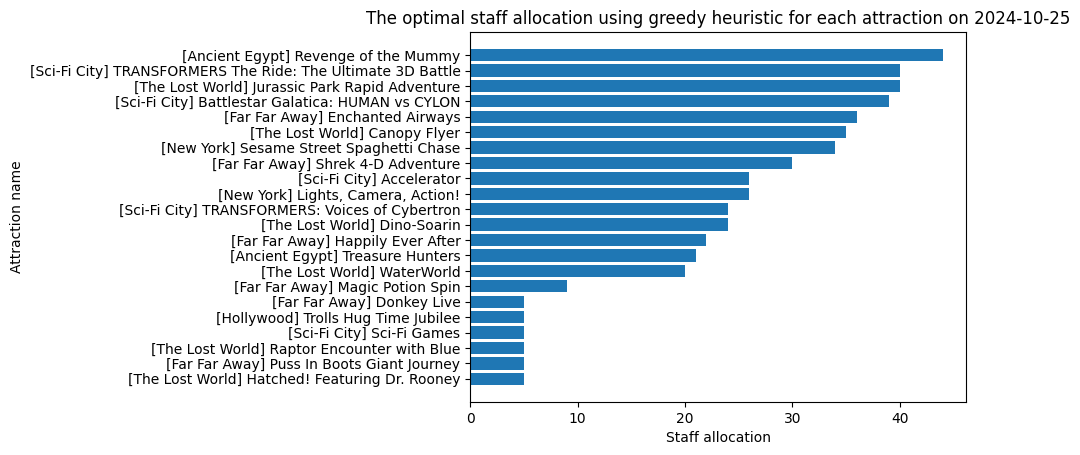

In [17]:
fig_greedy, ax_greedy = plt.subplots()
ax_greedy.barh(list(optimal_allocation_greedy.keys()), list(optimal_allocation_greedy.values()))
ax_greedy.set_xlabel("Staff allocation")
ax_greedy.set_ylabel("Attraction name")
ax_greedy.set_title(f"The optimal staff allocation using greedy heuristic for each attraction on {date}")
plt.show()

### Some thoughts on Greedy Heuristic

The attraction vs. staff allocation bar plot looks less similar in terms of proportionality to the attraction vs. wait times bar plot.

Since we are trying to minimise total wait time, it makes sense that the ride with the highest wait time would be prioritised to have more staff allocated to it. However, this time we allocate more in proportion to the rest of the rides. In a sense, it is slightly more uniform and less one-sided.

This greedy approach is good as it would always give a feasible solution. However, one of its limitation is that it assumes the wait time will always decrease when more staff is allocated to a ride. This may or may not be necessarily true.

### Comparison of the three bar plots above

This is to allow for easier comparison of the different plots. In order, the plots are:
1. Attraction vs. wait time
2. Attraction vs. optimal staff allocation (linear solution)
3. Attraction vs. optimal staff allocation (greedy solution)

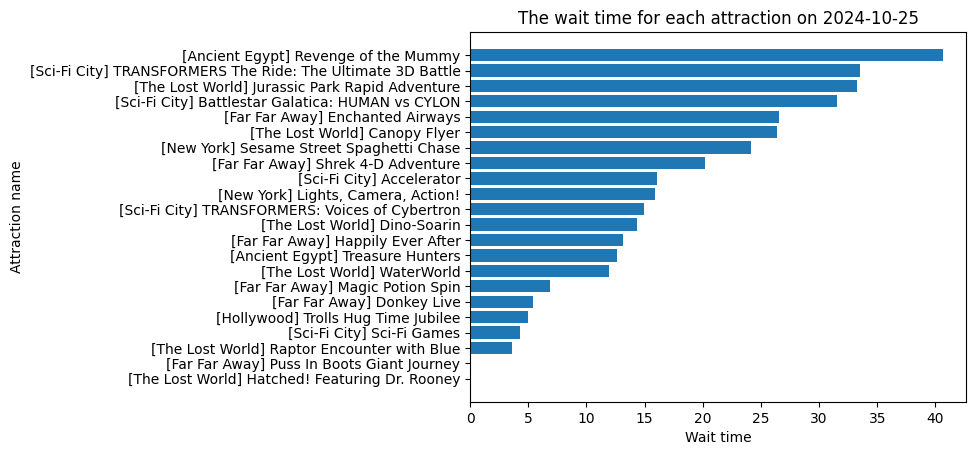

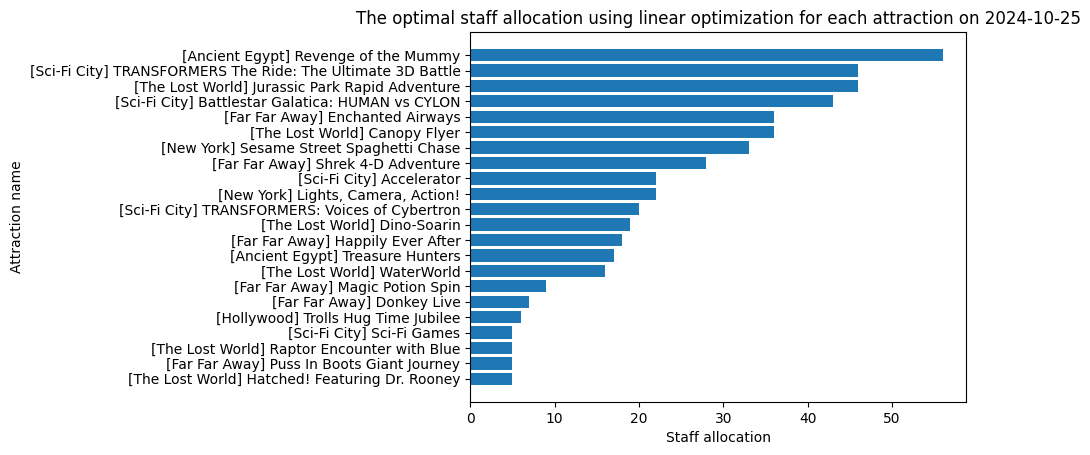

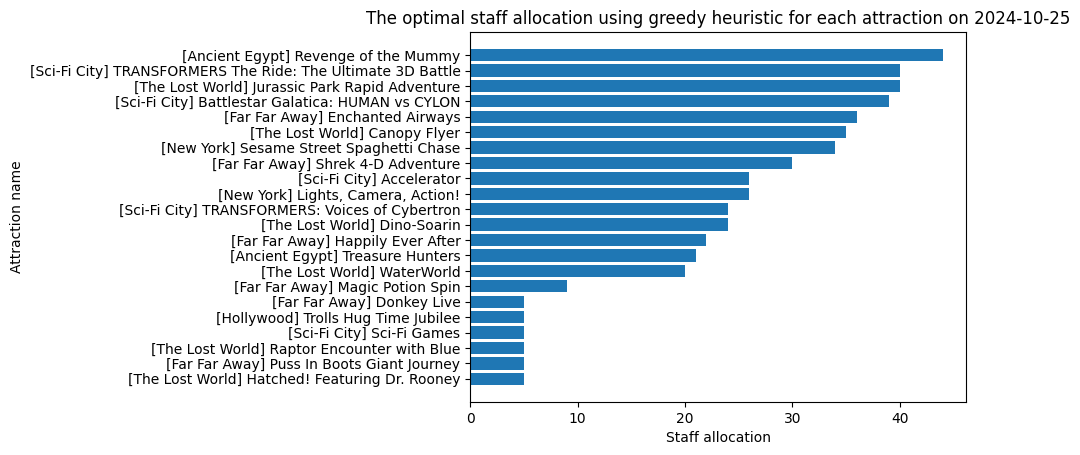

In [18]:
plt.figure(fig_forecast)
plt.show()

plt.figure(fig_linear)
plt.show()

plt.figure(fig_greedy)
plt.show()

### Visual comparison of optimal allocation for different number of staff

Here, we are going to compare how Linear Optimization and Greedy Heuristic allocates staff depending on the total number of staff and minimum number of staff. We are using the same example as earlier: 500 total staff, 5 minimum staff per attraction. For the other bar plot, we will be using 60 total staff, 1 minimum staff per attraction. We would like to see the extreme ends of the number of staff and how the two methods will optimize allocation.

In [19]:
def plot_allocation_comparison(date, optimal_allocation_linear, optimal_allocation_greedy, save_plot_name):
    y_pos = np.arange(len(attractions)) * 1.3

    staff_linear = list(optimal_allocation_linear.values())
    staff_greedy = list(optimal_allocation_greedy.values())

    fig, ax = plt.subplots(figsize=(10, 15))

    # Colour gradient
    blue_colors = plt.cm.Blues(np.linspace(0.5, 1, len(staff_linear)))
    green_colors = plt.cm.Greens(np.linspace(0.5, 1, len(staff_greedy)))
    for i in range(len(staff_linear)):
        ax.barh(y_pos[i] + 0.2, staff_linear[i], height=0.4, color=blue_colors[i], label='Linear Optimization' if i == 0 else "")
        ax.barh(y_pos[i] - 0.2, staff_greedy[i], height=0.4, color=green_colors[i], label='Greedy Heuristic' if i == 0 else "")

    # Place numbers beside bar plot
    for i, v in enumerate(staff_linear):
        ax.text(v + 0.5, y_pos[i] + 0.2, str(int(v)), color='blue', va='center')
    for i, v in enumerate(staff_greedy):
        ax.text(v + 0.5, y_pos[i] - 0.2, str(int(v)), color='green', va='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(attractions)
    ax.set_xlabel("Staff allocation")
    ax.set_ylabel("Attraction name")
    ax.set_title(f"Optimal Staff Allocation Comparison on {date}")

    ax.legend()

    # If non-empty, then save the file name as the string assigned to save_plot_name
    if save_plot_name:
        plt.savefig(save_plot_name + ".png", dpi=300, bbox_inches='tight')

    plt.show()

#### Optimal Allocation Comparison using Bar Plot for 500 total staff, 5 minimum staff per attraction

Linear Optimization allocates more staff to Revenge of the Mummy. The distribution of Linear Optimization is much better and makes more sense, as Revenge of the Mummy has a long wait time, and should be allocating more staff to that attraction.

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/9e956f7619274383bc50a408c2696a4a-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/9e956f7619274383bc50a408c2696a4a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 205 RHS
At line 251 BOUNDS
At line 274 ENDATA
Problem MODEL has 45 rows, 44 columns and 88 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 990 to -1.79769e+308
Probing was tried 0 times and creat

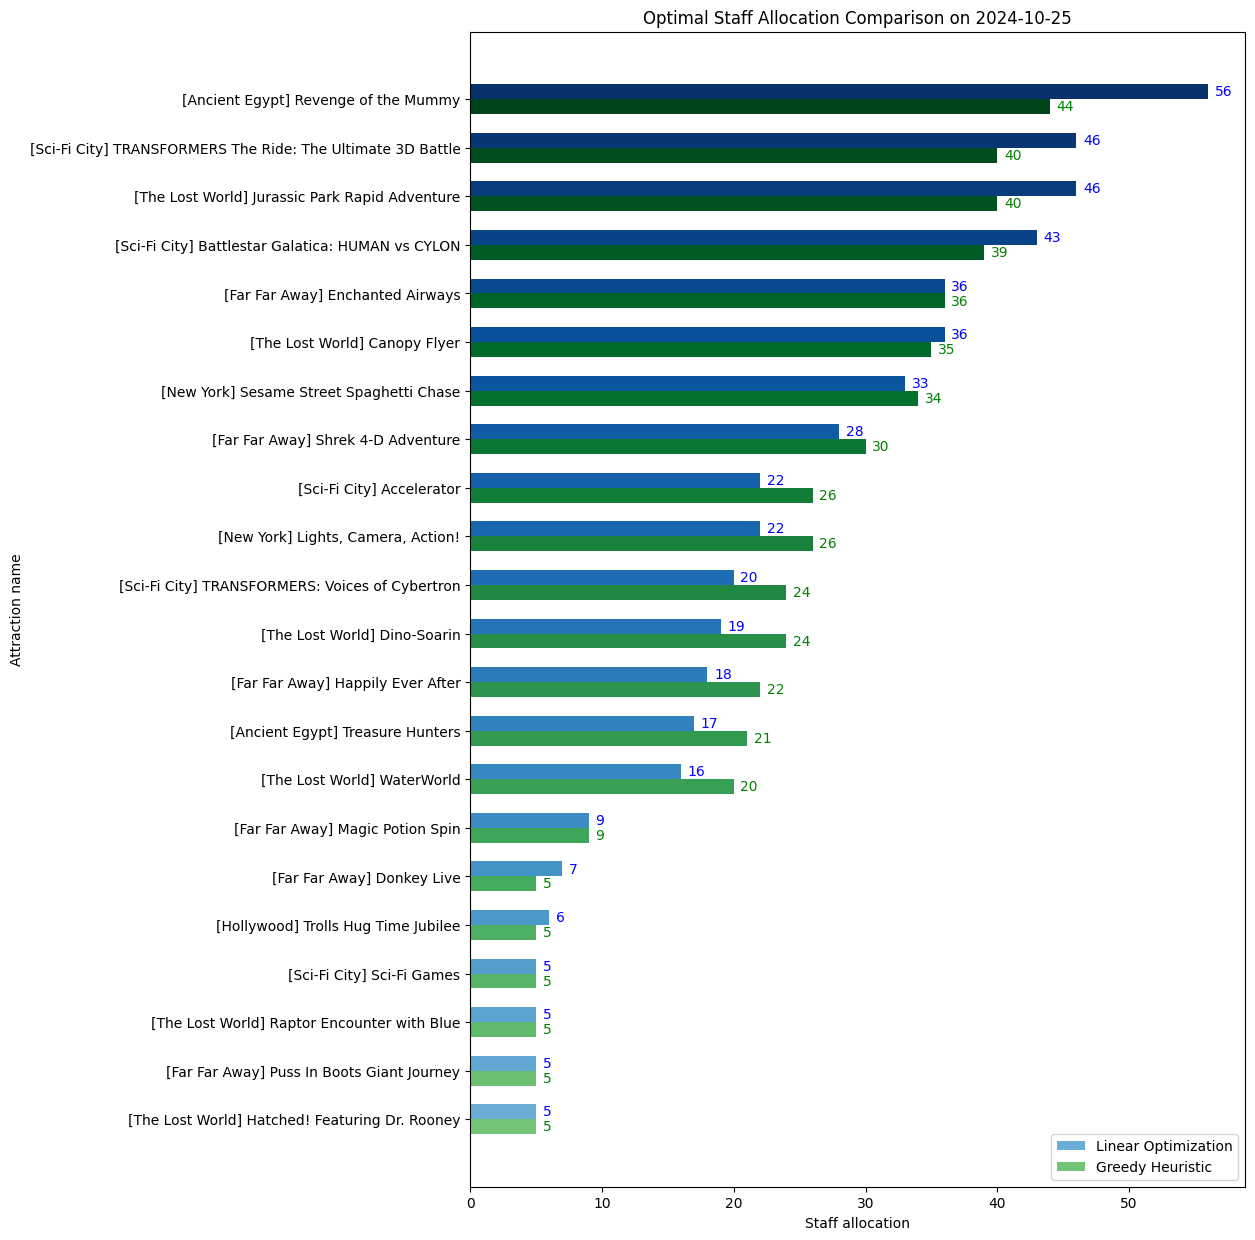

In [20]:
total_staff = 500
min_staff_per_attraction = 5

min_staff_per_attraction = check_min_staff(total_staff, min_staff_per_attraction)

optimal_allocation_linear, feasible = get_allocation_linear(date, total_staff, min_staff_per_attraction, True)
optimal_allocation_greedy = get_allocation_greedy(date, total_staff, min_staff_per_attraction, 0.95)

plot_allocation_comparison(date, optimal_allocation_linear, optimal_allocation_greedy, f"{total_staff} total, {min_staff_per_attraction} min")

#### Optimal Allocation Comparison using Bar Plot for 60 total staff, 1 minimum staff per attraction

Greedy Heuristic allocates more staff to Revenge of the Mummy. The distribution of Greedy Heuristic is much better and makes more sense, as Revenge of the Mummy has a long wait time, and should be allocating more staff to that attraction.

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/b946c4c5e89d49c3993a19116a193895-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/b946c4c5e89d49c3993a19116a193895-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 205 RHS
At line 251 BOUNDS
At line 274 ENDATA
Problem MODEL has 45 rows, 44 columns and 88 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 6 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 106 to -1.79769e+308
Probing was tried 0 times and create

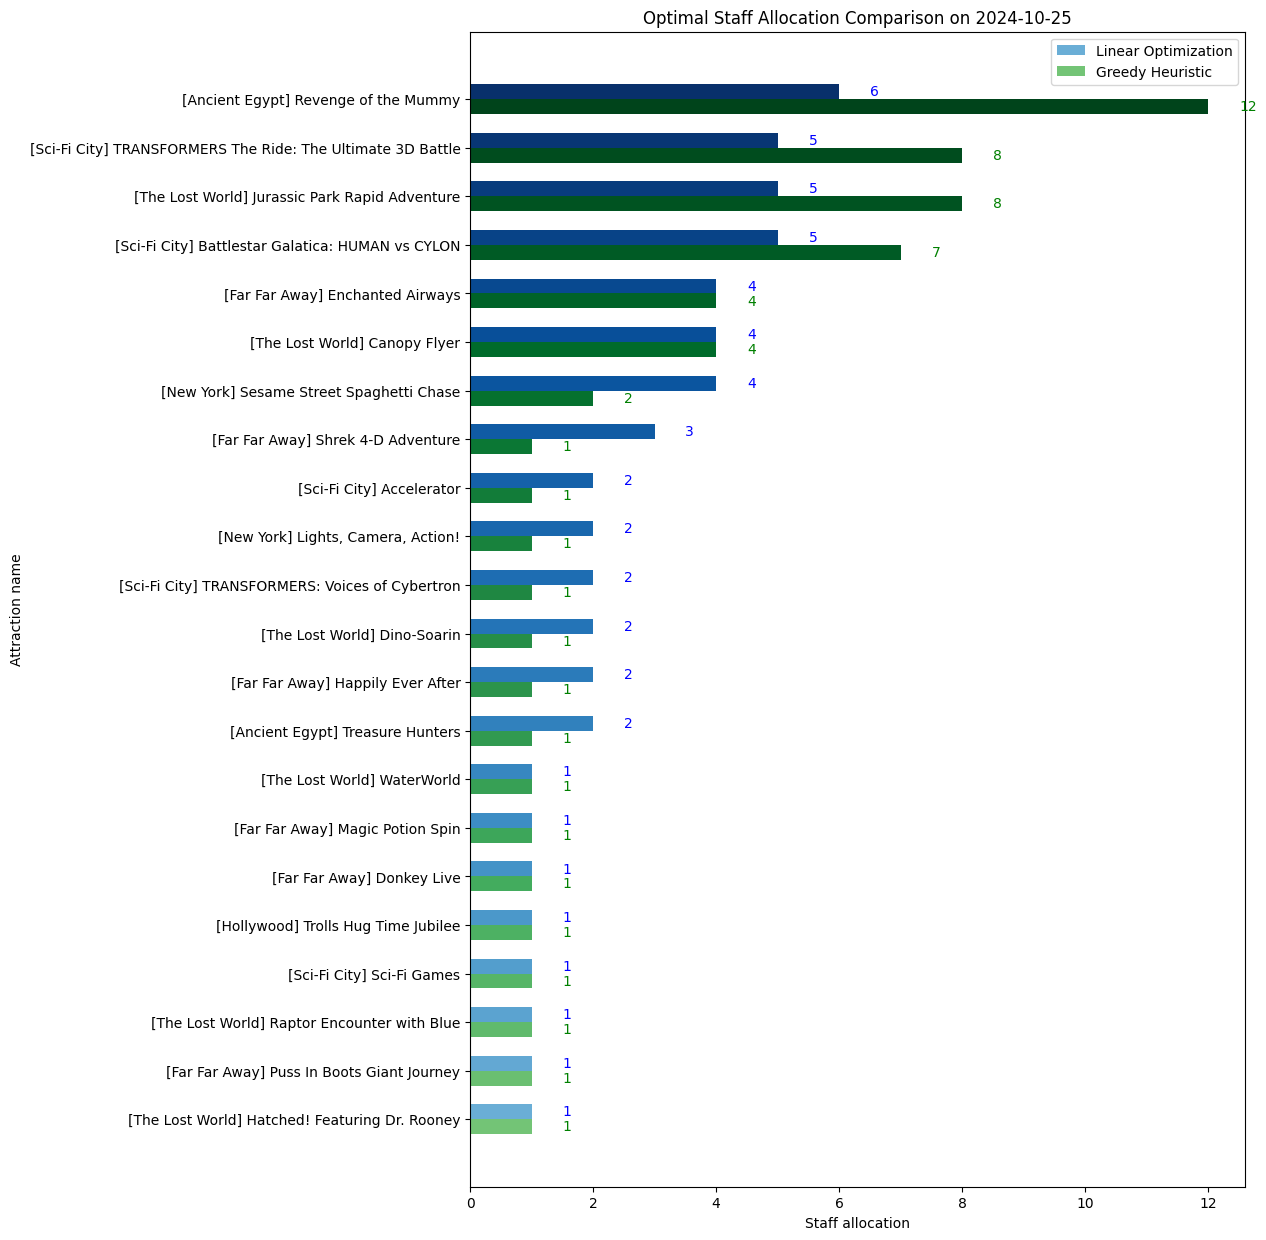

In [21]:
total_staff = 60
min_staff_per_attraction = 1

min_staff_per_attraction = check_min_staff(total_staff, min_staff_per_attraction)

optimal_allocation_linear, feasible = get_allocation_linear(date, total_staff, min_staff_per_attraction, True)
optimal_allocation_greedy = get_allocation_greedy(date, total_staff, min_staff_per_attraction, 0.95)

plot_allocation_comparison(date, optimal_allocation_linear, optimal_allocation_greedy, f"{total_staff} total, {min_staff_per_attraction} min")

### Important key findings for both models

We shall make a line plot. This line plot will consist of two lines, one for Linear Optimization, one for Greedy Heuristic. The y-axis will be the number of staff allocated to the attraction with the highest wait time. The x-axis will be the total number of staff to be used for allocation. We will be assuming each attraction requires 1 staff to be allocated. Thus, our lowest total staff allocated will be exactly the number of allocations, and will go up to a high number like 500.

We see that Linear Optimization has a linear increase. This could be attributed to the way the objective function and constraints are set up in the Linear Optimization. It is trying to minimise the deviation from the target allocation, and the target allocation according to it seems to be proportionate to the attraction vs. wait times bar plot. This means as there are more total staff, it will just allocate more and more proportionately, maintaining the distribution, so the increase is linear. 

We also see that Greedy Heuristic has a logarithmic increase. This could be attributed to the way the way the total wait time is being decreased, which is an exponential decrease. For every 1 staff allocated, the wait time for that attraction is multiplied by 0.95, or any other factor that we can choose. The exponential decrease in wait time might explain the logarithmic increase in allocation to the attraction with highest forecasted wait time.

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/a696e51d3aa74a4d9d931c25fc4108a8-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/a696e51d3aa74a4d9d931c25fc4108a8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 205 RHS
At line 251 BOUNDS
At line 274 ENDATA
Problem MODEL has 45 rows, 44 columns and 88 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.frame

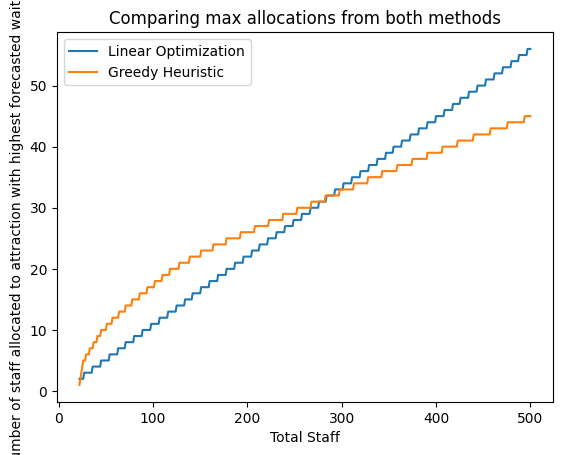

In [22]:
total_staffs = [i for i in range(num_of_attractions, 501)]
max_linear_allocations = []
max_greedy_allocations = []
intersections = []

for total_staff in total_staffs:
    min_staff_per_attraction = 1
    min_staff_per_attraction = check_min_staff(total_staff, min_staff_per_attraction)

    # Get the optimal allocations from both methods
    optimal_allocation_linear, feasible = get_allocation_linear(date, total_staff, min_staff_per_attraction, False)
    optimal_allocation_greedy = get_allocation_greedy(date, total_staff, min_staff_per_attraction, 0.95)

    # Get the highest allocation from Linear Optimization and Greedy Heuristic
    max_linear = max(optimal_allocation_linear.items(), key = lambda x: x[1])[1]
    max_greedy = max(optimal_allocation_greedy.items(), key = lambda x: x[1])[1]

    if max_linear == max_greedy:
        intersections.append((total_staff, max_linear))

    max_linear_allocations.append(max_linear)
    max_greedy_allocations.append(max_greedy)

plt.plot(total_staffs, max_linear_allocations, label = "Linear Optimization")
plt.plot(total_staffs, max_greedy_allocations, label = "Greedy Heuristic")

plt.xlabel("Total Staff")
plt.ylabel("Number of staff allocated to attraction with highest forecasted wait time")
plt.legend()
plt.title("Comparing max allocations from both methods")

plt.show()

#### Intersections in staff allocation

We see that there are two intersections, where both models allocated the same number of staff to the attraction with the highest wait time. This gives us an incentive to generate a bar plot for one of the intersections to see what the distributions of the two models would look like.

In [23]:
for (total_staff, staff_allocated) in intersections:
    print(f"Total staff: {total_staff}, staff allocated: {int(staff_allocated)}")

Total staff: 23, staff allocated: 2
Total staff: 267, staff allocated: 30
Total staff: 276, staff allocated: 31
Total staff: 277, staff allocated: 31
Total staff: 278, staff allocated: 31
Total staff: 279, staff allocated: 31
Total staff: 280, staff allocated: 31
Total staff: 281, staff allocated: 31
Total staff: 282, staff allocated: 31
Total staff: 284, staff allocated: 32
Total staff: 285, staff allocated: 32
Total staff: 286, staff allocated: 32
Total staff: 287, staff allocated: 32
Total staff: 288, staff allocated: 32
Total staff: 289, staff allocated: 32
Total staff: 290, staff allocated: 32
Total staff: 291, staff allocated: 32
Total staff: 292, staff allocated: 32
Total staff: 298, staff allocated: 33
Total staff: 299, staff allocated: 33
Total staff: 300, staff allocated: 33
Total staff: 301, staff allocated: 33


#### Optimal Allocation Comparison using Bar Plot for any total staff that causes same allocation to attraction with highest forecasted wait time, 1 minimum staff per attraction

Generally, Linear Optimization follows the distribution of attraction vs wait times. more closely. This is likely attributed to the objective function, which minimises deviation from the target allocation, and it follows the distribution more proportionately.

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/e87803265f07474d8290bf0781d95523-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/e87803265f07474d8290bf0781d95523-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 205 RHS
At line 251 BOUNDS
At line 274 ENDATA
Problem MODEL has 45 rows, 44 columns and 88 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 548 to -1.79769e+308
Probing was tried 0 times and create

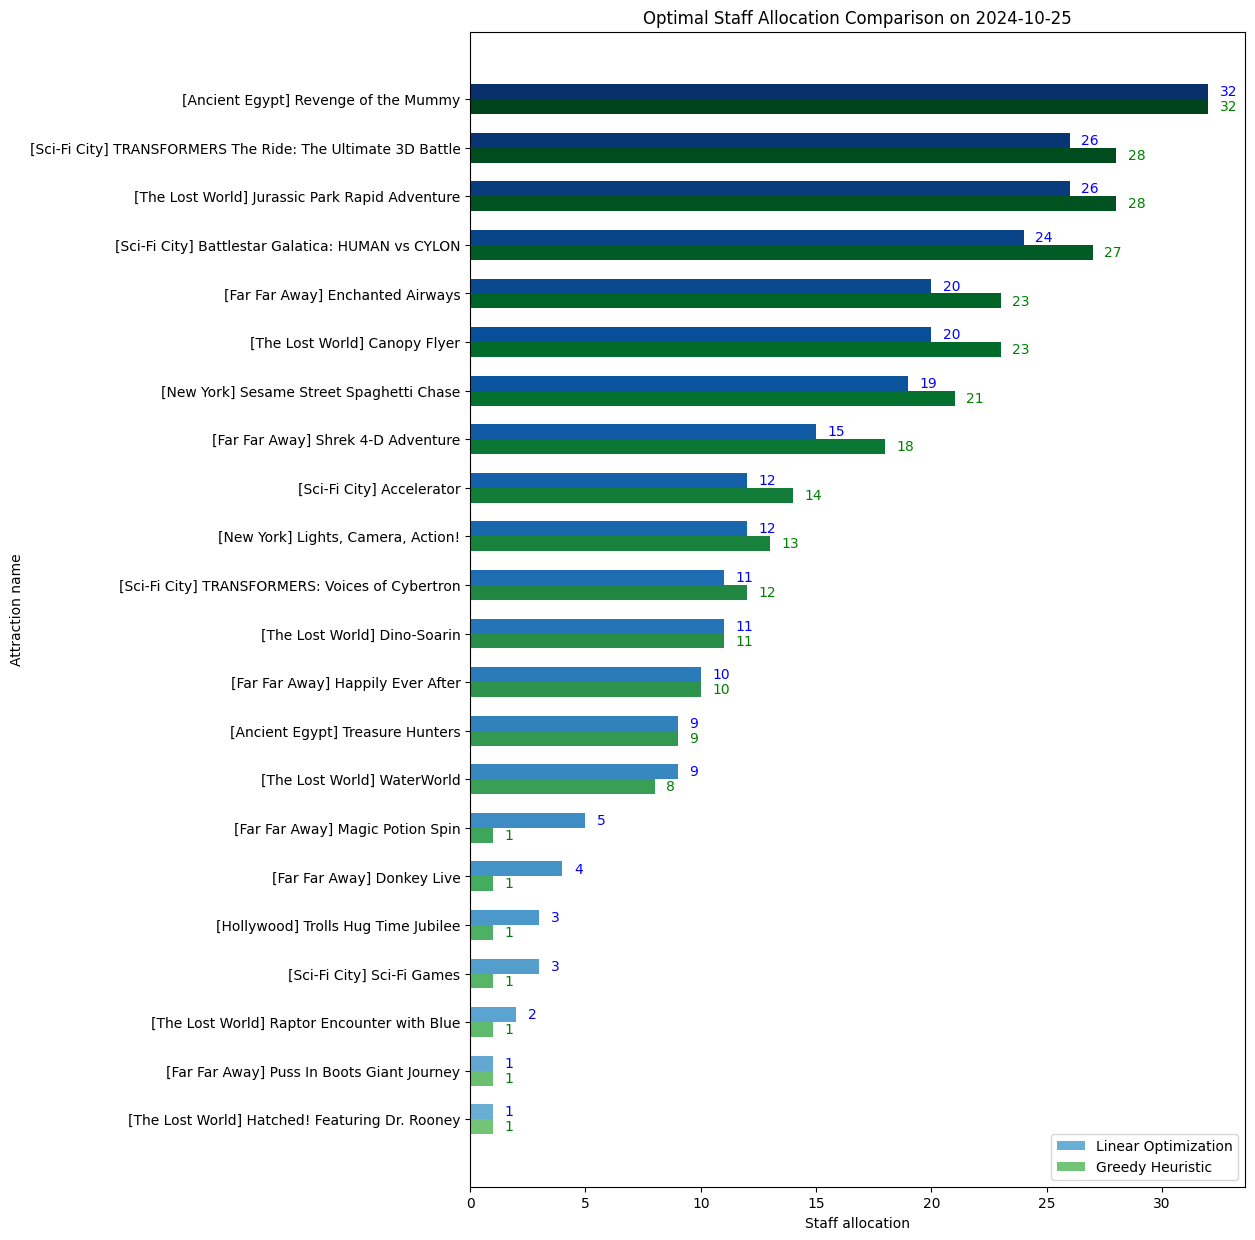

In [24]:
index = randint(0, len(intersections)-1)

total_staff = intersections[index][0]
min_staff_per_attraction = 1

min_staff_per_attraction = check_min_staff(total_staff, min_staff_per_attraction)

optimal_allocation_linear, feasible = get_allocation_linear(date, total_staff, min_staff_per_attraction, True)
optimal_allocation_greedy = get_allocation_greedy(date, total_staff, min_staff_per_attraction, 0.95)

plot_allocation_comparison(date, optimal_allocation_linear, optimal_allocation_greedy, f"{total_staff} total, {min_staff_per_attraction} min")

### Diving more into Greedy Heuristic

We are looking into how reduction factor can affect the allocation of Greedy Heuristic, mainly the allocation to the attraction with highest wait time. We consider the reduction factors 0.90, 0.91, ..., 0.98, 0.99. As seen below, the higher the reduction factor, the more staff allocated to the attraction with highest wait time.

We can stick to using 0.95 as our reduction factor since it offers a balanced amount of staff allocation, not too high, not too low. It is not wise to put too many staff into one attraction as they may not be able to contribute much when there's already a lot of staff present, so it is better to allocate them to other attractions.

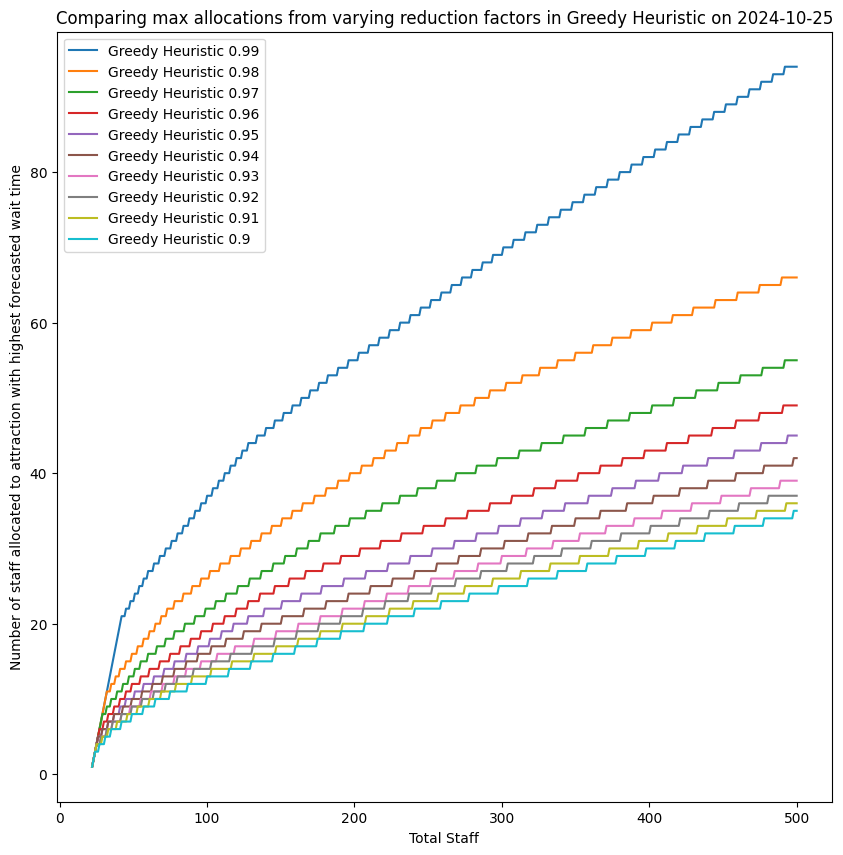

In [25]:
total_staffs = [i for i in range(num_of_attractions, 501)]

num_of_reduction_factors = 10
max_greedy_allocations = [[] for _ in range(num_of_reduction_factors)]
reduction_factors = [(100-num_of_reduction_factors+i)/100 for i in range(num_of_reduction_factors)]

for total_staff in total_staffs:
    min_staff_per_attraction = 1
    min_staff_per_attraction = check_min_staff(total_staff, min_staff_per_attraction)

    # Get the optimal allocations from Greedy Heuristics
    for i in range(num_of_reduction_factors):
        optimal_allocation_greedy_rf = get_allocation_greedy(date, total_staff, min_staff_per_attraction, reduction_factors[i])
        max_greedy_rf = max(optimal_allocation_greedy_rf.items(), key = lambda x: x[1])[1]
        max_greedy_allocations[i].append(max_greedy_rf)

plt.figure(figsize=(10, 10))

for i in range(num_of_reduction_factors-1, -1, -1):
    plt.plot(total_staffs, max_greedy_allocations[i], label = f"Greedy Heuristic {reduction_factors[i]}")

plt.xlabel("Total Staff")
plt.ylabel("Number of staff allocated to attraction with highest forecasted wait time")
plt.legend()
plt.title(f"Comparing max allocations from varying reduction factors in Greedy Heuristic on {date}")

plt.show()

### Miscellaneous Analysis

Comparing time taken for Linear Optimization to find a solution vs time taken for Greedy Heuristic to find a solution. Since they are both relatively quick, taking milliseconds to run, this comparison is rather trivial.

In [26]:
date = all_dates[randint(0, all_dates.shape[0]-1)]
total_staff = 250
min_staff_per_attraction = 3
reduction_factor = 0.95

linear_start = time.time()
get_allocation_linear(date, total_staff, min_staff_per_attraction, False)
linear_end = time.time()

greedy_start = time.time()
get_allocation_greedy(date, total_staff, min_staff_per_attraction, reduction_factor)
greedy_end = time.time()

print(f"Linear Optimization time taken: {linear_end - linear_start} seconds")
print(f"Greedy Heuristic time taken: {greedy_end - greedy_start} seconds")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/6236b9ae05cc4840829db87a038e7ba1-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/6236b9ae05cc4840829db87a038e7ba1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 205 RHS
At line 251 BOUNDS
At line 274 ENDATA
Problem MODEL has 45 rows, 44 columns and 88 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 490 to -1.79769e+308
Probing was tried 0 times and create

## Deciding which allocation to use

We will choose the model that allocates more to the attraction with highest forecasted wait time. We do so as it not only makes the most sense, but the relevant model follows more closely to the distribution of the bar plot in the attraction vs. wait times. This decision is done inside the choose_allocation function that picks the better allocation, showing the number of staff allocation per attraction, and shows the bar plot showing the allocation comparison.

Additionally, there are multiple intersections where both models allocate the same number of staff to the attraction with the highest wait time. At that point, Linear Optimization follows the distribution of attraction vs. wait times more closely, so we will be choosing Linear Optimization over Greedy Heuristic when the allocations to the attraction with the highest wait times are tied.

The caveat is that sometimes, a more uniform distribution can be better, where the staff allocation is not all focused on the attraction with the highest wait time, but also consider the rest of the attractions. This is why the choice given by the model is likely one with good reasoning, but it ultimately depends on the user who decides the allocation. Having two different allocations means that the user can choose to pick the one not recommended by our model, should they see it being more fit to handle the guests waiting.

In [27]:
def choose_allocation(date, total_staff, min_staff_per_attraction, reduction_factor, save_plot_name):
    # Check if minimum staff per attraction is logical
    min_staff_per_attraction = check_min_staff(total_staff, min_staff_per_attraction)

    # Get the optimal allocations from both methods
    optimal_allocation_linear, feasible = get_allocation_linear(date, total_staff, min_staff_per_attraction, False)
    optimal_allocation_greedy = get_allocation_greedy(date, total_staff, min_staff_per_attraction, reduction_factor)

    # Linear Optimization not feasible
    if not feasible:
        print("Choose the allocation provided by Greedy Heuristic.")
        return dict(sorted(optimal_allocation_greedy.items(), key = lambda x: x[0]))

    # Get the highest allocation from Linear Optimization and Greedy Heuristic
    max_linear = max(optimal_allocation_linear.items(), key = lambda x: x[1])[1]
    max_greedy = max(optimal_allocation_greedy.items(), key = lambda x: x[1])[1]

    # Highest allocation of Linear Optimization >= Highest allocation of Greedy Heuristic
    if max_linear >= max_greedy:
        print("Choose the allocation provided by Linear Optimization.\n")

        total_staff_used = 0
        for (k,v) in sorted(optimal_allocation_linear.items(), key = lambda x: x[0]):
            print(f"{k}: {int(v)} staff")
            total_staff_used += int(v)
        print(f"\nTotal staff allocated: {total_staff_used}\n")
            
        # Bar plot showing the allocation comparison
        plot_allocation_comparison(date, optimal_allocation_linear, optimal_allocation_greedy, save_plot_name)
    
    # Highest allocation of Linear Optimization < Highest allocation of Greedy Heuristic
    else:
        print("Choose the allocation provided by Greedy Heuristic.\n")

        total_staff_used = 0
        for (k,v) in sorted(optimal_allocation_greedy.items(), key = lambda x: x[0]):
            print(f"{k}: {int(v)} staff")
            total_staff_used += int(v)
        print(f"\nTotal staff allocated: {total_staff_used}\n")
        
        # Bar plot showing the allocation comparison
        plot_allocation_comparison(date, optimal_allocation_linear, optimal_allocation_greedy, save_plot_name)

### Usage

The user is able to pick a certain day within the forecasted wait times. They can then change the total number of staff to handle the attractions. They also can change the minimum number staff that is required per attraction. The reduction factor for Greedy Heuristic is defaulted to be 0.95, but the user can also change it if needed. They can choose to save the plot as a .png image.

The code will check the min staff per attraction, ensuring it is logical. It gets the optimal allocations of Linear Optimization and Greedy Heuristic, decides the optimal allocation and shows it immediately at the top. It also shows the number of staff to be allocated per attraction, sorted by attraction name in increasing order, allowing the user to allocate easily. It will also show the visual comparison of allocation using bar plot below.

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/bf741a9e7e6b4a369796f2f3cfa82363-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/nk/3csp0q8n1215gpyq8xxqzksc0000gn/T/bf741a9e7e6b4a369796f2f3cfa82363-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 50 COLUMNS
At line 205 RHS
At line 251 BOUNDS
At line 274 ENDATA
Problem MODEL has 45 rows, 44 columns and 88 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 7 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 83 to -1.79769e+308
Probing was tried 0 times and created

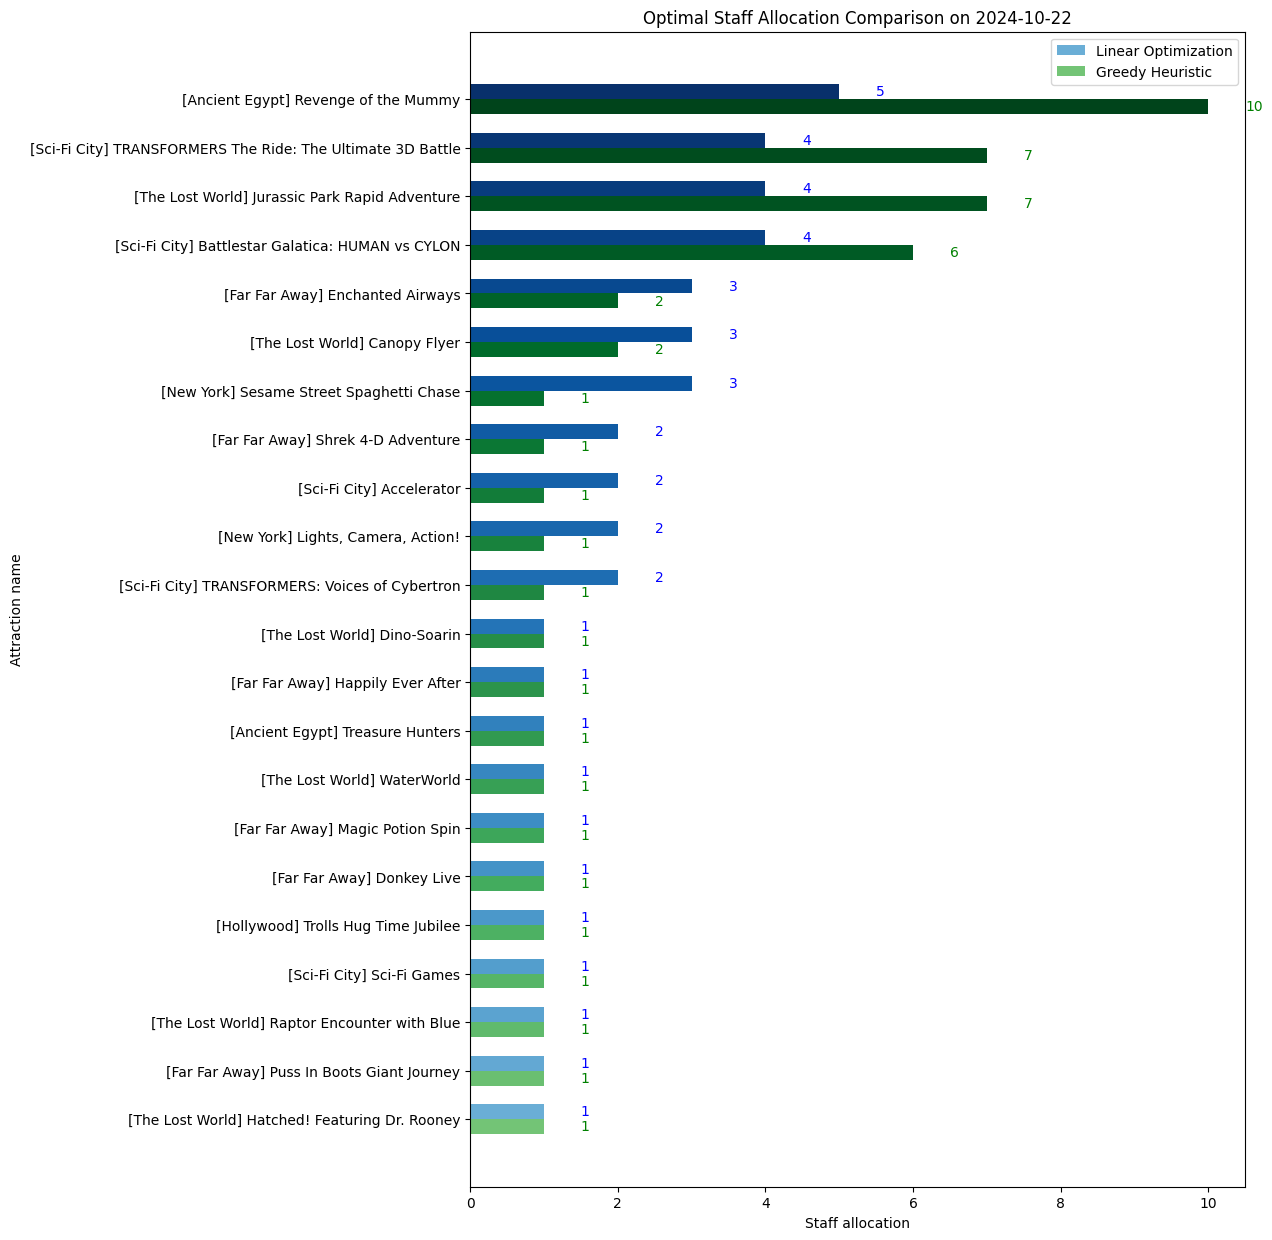

In [28]:
date = all_dates[randint(0, all_dates.shape[0]-1)]
total_staff = 50
min_staff_per_attraction = 1
reduction_factor = 0.95
image_name = ""

choose_allocation(date, total_staff, min_staff_per_attraction, reduction_factor, image_name)